In [1]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn 
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
rfm_and_country_df = pd.read_csv('../datasets/UK_Online_Retail/rfm_and_country.csv')
try:
    rfm_and_country_df.drop(columns=['CustomerID.1'], inplace=True)
except KeyError:
    pass
rfm_and_country_df

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,Country,RecencyScore,FrequencyScore,MonetaryScore,RecencyScoreText,FrequencyScoreText,MonetaryScoreText
0,0,12346.0,326,2,0.00,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
1,1,12347.0,2,182,4310.00,Iceland,5.0,5.0,5.0,very recently,very frequently,a lot of money
2,2,12348.0,75,31,1797.24,Finland,2.0,3.0,4.0,some time ago,somewhat frequently,some money
3,3,12349.0,19,73,1757.55,Italy,4.0,4.0,4.0,recently,frequently,some money
4,4,12350.0,310,17,334.40,Norway,1.0,2.0,2.0,a very long time ago,rarely,a little money
...,...,...,...,...,...,...,...,...,...,...,...,...
4367,4367,18280.0,278,10,180.60,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4368,4368,18281.0,181,7,80.82,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4369,4369,18282.0,8,13,176.60,United Kingdom,5.0,1.0,1.0,very recently,extremely rarely,only a very little money
4370,4370,18283.0,4,756,2094.88,United Kingdom,5.0,5.0,5.0,very recently,very frequently,a lot of money


In [3]:
rfm_and_country_df.describe()

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,2185.500000,15299.677722,92.047118,93.053294,1898.459701,3.010522,2.984904,3.000000
std,1262.232018,1722.390705,100.765435,232.471608,8219.345147,1.416276,1.424771,1.414699
min,0.000000,12346.000000,1.000000,1.000000,-4287.630000,1.000000,1.000000,1.000000
25%,1092.750000,13812.750000,17.000000,17.000000,293.362500,2.000000,2.000000,2.000000
50%,2185.500000,15300.500000,50.000000,42.000000,648.075000,3.000000,3.000000,3.000000
75%,3278.250000,16778.250000,143.000000,102.000000,1611.725000,4.000000,4.000000,4.000000
max,4371.000000,18287.000000,374.000000,7983.000000,279489.030000,5.000000,5.000000,5.000000


In [4]:
# rfm_df.set_index('customer_id')

from sklearn.preprocessing import MinMaxScaler

rfm_and_country_df_scaled = rfm_and_country_df.copy()
scaler = MinMaxScaler()
rfm_and_country_df_scaled.iloc[:, 1:4] = scaler.fit_transform(rfm_and_country_df.iloc[:, 1:4])
rfm_and_country_df_scaled

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,Country,RecencyScore,FrequencyScore,MonetaryScore,RecencyScoreText,FrequencyScoreText,MonetaryScoreText
0,0,0.000000,0.871314,0.000125,0.00,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
1,1,0.000168,0.002681,0.022676,4310.00,Iceland,5.0,5.0,5.0,very recently,very frequently,a lot of money
2,2,0.000337,0.198391,0.003758,1797.24,Finland,2.0,3.0,4.0,some time ago,somewhat frequently,some money
3,3,0.000505,0.048257,0.009020,1757.55,Italy,4.0,4.0,4.0,recently,frequently,some money
4,4,0.000673,0.828418,0.002005,334.40,Norway,1.0,2.0,2.0,a very long time ago,rarely,a little money
...,...,...,...,...,...,...,...,...,...,...,...,...
4367,4367,0.998822,0.742627,0.001128,180.60,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4368,4368,0.998990,0.482574,0.000752,80.82,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4369,4369,0.999158,0.018767,0.001503,176.60,United Kingdom,5.0,1.0,1.0,very recently,extremely rarely,only a very little money
4370,4370,0.999327,0.008043,0.094588,2094.88,United Kingdom,5.0,5.0,5.0,very recently,very frequently,a lot of money


In [5]:
rfm_and_country_df_scaled.iloc[:, 1:4]

,CustomerID,Recency,Frequency
0,0.000000,0.871314,0.000125
1,0.000168,0.002681,0.022676
2,0.000337,0.198391,0.003758
3,0.000505,0.048257,0.009020
4,0.000673,0.828418,0.002005
...,...,...,...
4367,0.998822,0.742627,0.001128
4368,0.998990,0.482574,0.000752
4369,0.999158,0.018767,0.001503
4370,0.999327,0.008043,0.094588


In [6]:
rfm_and_country_df

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,Country,RecencyScore,FrequencyScore,MonetaryScore,RecencyScoreText,FrequencyScoreText,MonetaryScoreText
0,0,12346.0,326,2,0.00,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
1,1,12347.0,2,182,4310.00,Iceland,5.0,5.0,5.0,very recently,very frequently,a lot of money
2,2,12348.0,75,31,1797.24,Finland,2.0,3.0,4.0,some time ago,somewhat frequently,some money
3,3,12349.0,19,73,1757.55,Italy,4.0,4.0,4.0,recently,frequently,some money
4,4,12350.0,310,17,334.40,Norway,1.0,2.0,2.0,a very long time ago,rarely,a little money
...,...,...,...,...,...,...,...,...,...,...,...,...
4367,4367,18280.0,278,10,180.60,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4368,4368,18281.0,181,7,80.82,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4369,4369,18282.0,8,13,176.60,United Kingdom,5.0,1.0,1.0,very recently,extremely rarely,only a very little money
4370,4370,18283.0,4,756,2094.88,United Kingdom,5.0,5.0,5.0,very recently,very frequently,a lot of money


In [7]:
rfm_copy = rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]]
rfm_copy


,RecencyScore,FrequencyScore,MonetaryScore
0,1.0,1.0,1.0
1,5.0,5.0,5.0
2,2.0,3.0,4.0
3,4.0,4.0,4.0
4,1.0,2.0,2.0
...,...,...,...
4367,1.0,1.0,1.0
4368,1.0,1.0,1.0
4369,5.0,1.0,1.0
4370,5.0,5.0,5.0


In [8]:
# from sklearn.pipeline import Pipeline

# # https://github.com/yzhao062/pyod
# clf = ECOD()

# clf.fit(rfm_and_country_df_scaled.iloc[:, 1:4])
# outliers = clf.predict(rfm_and_country_df_scaled.iloc[:, 1:4])

# rfm_and_country_df_scaled['outlier'] = outliers
# rfm_and_country_df['outlier'] = outliers

# rfm_scaled_no_outliers = rfm_and_country_df[rfm_and_country_df_scaled['outlier'] == 0]
# rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

# rfm_scaled_no_outliers

from sklearn.pipeline import Pipeline

# https://github.com/yzhao062/pyod
clf = ECOD()

clf.fit(rfm_copy)
outliers = clf.predict(rfm_copy)

rfm_and_country_df_scaled['outlier'] = outliers
rfm_and_country_df['outlier'] = outliers

rfm_scaled_no_outliers = rfm_and_country_df[rfm_and_country_df_scaled['outlier'] == 0]
rfm_and_country_df = rfm_and_country_df[rfm_and_country_df['outlier'] == 0]
rfm_and_country_df = rfm_and_country_df.drop('outlier', axis=1)
rfm_scaled_no_outliers = rfm_scaled_no_outliers.drop('outlier', axis=1)

rfm_and_country_df

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,Country,RecencyScore,FrequencyScore,MonetaryScore,RecencyScoreText,FrequencyScoreText,MonetaryScoreText
0,0,12346.0,326,2,0.00,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
2,2,12348.0,75,31,1797.24,Finland,2.0,3.0,4.0,some time ago,somewhat frequently,some money
3,3,12349.0,19,73,1757.55,Italy,4.0,4.0,4.0,recently,frequently,some money
4,4,12350.0,310,17,334.40,Norway,1.0,2.0,2.0,a very long time ago,rarely,a little money
5,5,12352.0,36,95,1545.41,Norway,3.0,4.0,4.0,no so recently,frequently,some money
...,...,...,...,...,...,...,...,...,...,...,...,...
4366,4366,18278.0,74,9,173.90,United Kingdom,2.0,1.0,1.0,some time ago,extremely rarely,only a very little money
4367,4367,18280.0,278,10,180.60,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4368,4368,18281.0,181,7,80.82,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money
4369,4369,18282.0,8,13,176.60,United Kingdom,5.0,1.0,1.0,very recently,extremely rarely,only a very little money


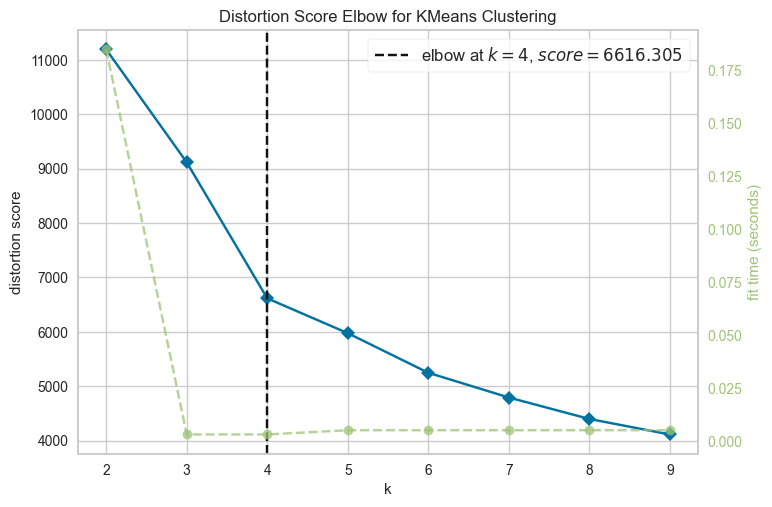

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
kmeans = KMeans(init='k-means++', random_state=0, n_init='auto')

visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]])
visualizer.show()

In [10]:
def make_Silhouette_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])  
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
range_n_clusters = list(range(2,10))
for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhouette_plot(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]], n_clusters)   
    plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()

N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.418345651258205
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.3669806624586728
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.3554999844207868
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.3518808532532839
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.3479965653384152
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.34486218091368936
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.3291525373044727
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.32989489989902987


In [11]:
n_clusters=5

In [12]:
km = KMeans(n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]])
print(km.inertia_)

5655.8755673940595


In [13]:
np.unique(clusters_predict)

array([0, 1, 2, 3, 4])

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print("Davies Bouldin Score: ", davies_bouldin_score(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print("Calinski Score: ", calinski_harabasz_score(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))

"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print("Silhouette Score: ", silhouette_score(rfm_and_country_df[["RecencyScore", "FrequencyScore", "MonetaryScore"]], clusters_predict))


Davies Bouldin Score:  1.0433359603178822
Calinski Score:  2955.149469721259


Silhouette Score:  0.34001381756617655


In [15]:
def label_country(df):
    # assign a label to each country
    country_label = OrdinalEncoder()
    country_label.fit(df[['Country']])
    df['CountryLabel'] = country_label.transform(df[['Country']])
    return df

rfm_and_country_df = label_country(rfm_and_country_df)
rfm_and_country_df

,Unnamed: 0,CustomerID,Recency,Frequency,MonetaryValue,Country,RecencyScore,FrequencyScore,MonetaryScore,RecencyScoreText,FrequencyScoreText,MonetaryScoreText,CountryLabel
0,0,12346.0,326,2,0.00,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money,34.0
2,2,12348.0,75,31,1797.24,Finland,2.0,3.0,4.0,some time ago,somewhat frequently,some money,12.0
3,3,12349.0,19,73,1757.55,Italy,4.0,4.0,4.0,recently,frequently,some money,17.0
4,4,12350.0,310,17,334.40,Norway,1.0,2.0,2.0,a very long time ago,rarely,a little money,23.0
5,5,12352.0,36,95,1545.41,Norway,3.0,4.0,4.0,no so recently,frequently,some money,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4366,4366,18278.0,74,9,173.90,United Kingdom,2.0,1.0,1.0,some time ago,extremely rarely,only a very little money,34.0
4367,4367,18280.0,278,10,180.60,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money,34.0
4368,4368,18281.0,181,7,80.82,United Kingdom,1.0,1.0,1.0,a very long time ago,extremely rarely,only a very little money,34.0
4369,4369,18282.0,8,13,176.60,United Kingdom,5.0,1.0,1.0,very recently,extremely rarely,only a very little money,34.0


In [16]:
# keep only the columns we need
rfm_and_country_df = rfm_and_country_df.loc[:, ['CustomerID', 'RecencyScore', 'FrequencyScore', 'MonetaryScore', 'CountryLabel']]
rfm_and_country_df

,CustomerID,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
0,12346.0,1.0,1.0,1.0,34.0
2,12348.0,2.0,3.0,4.0,12.0
3,12349.0,4.0,4.0,4.0,17.0
4,12350.0,1.0,2.0,2.0,23.0
5,12352.0,3.0,4.0,4.0,23.0
...,...,...,...,...,...
4366,18278.0,2.0,1.0,1.0,34.0
4367,18280.0,1.0,1.0,1.0,34.0
4368,18281.0,1.0,1.0,1.0,34.0
4369,18282.0,5.0,1.0,1.0,34.0


In [17]:
rfm_and_country_df.iloc[:, 1:5]

,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
0,1.0,1.0,1.0,34.0
2,2.0,3.0,4.0,12.0
3,4.0,4.0,4.0,17.0
4,1.0,2.0,2.0,23.0
5,3.0,4.0,4.0,23.0
...,...,...,...,...
4366,2.0,1.0,1.0,34.0
4367,1.0,1.0,1.0,34.0
4368,1.0,1.0,1.0,34.0
4369,5.0,1.0,1.0,34.0


In [18]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()

    fig = px.scatter_3d(df, 
                        x=columns[0], 
                        y=columns[1], 
                        z=columns[2],
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    columns = df.columns[0:3].tolist()


    fig = px.scatter(df, 
                        x=columns[0], 
                        y=columns[1],
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800, 
                                height = 700, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                        
        
    fig.show()


In [19]:
km = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters_predict = km.fit_predict(rfm_and_country_df.iloc[:, 1:5])
print('Cluster Inertia : ', km.inertia_)

Cluster Inertia :  13965.50002318221


In [20]:
rfm_and_country_df

,CustomerID,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
0,12346.0,1.0,1.0,1.0,34.0
2,12348.0,2.0,3.0,4.0,12.0
3,12349.0,4.0,4.0,4.0,17.0
4,12350.0,1.0,2.0,2.0,23.0
5,12352.0,3.0,4.0,4.0,23.0
...,...,...,...,...,...
4366,18278.0,2.0,1.0,1.0,34.0
4367,18280.0,1.0,1.0,1.0,34.0
4368,18281.0,1.0,1.0,1.0,34.0
4369,18282.0,5.0,1.0,1.0,34.0


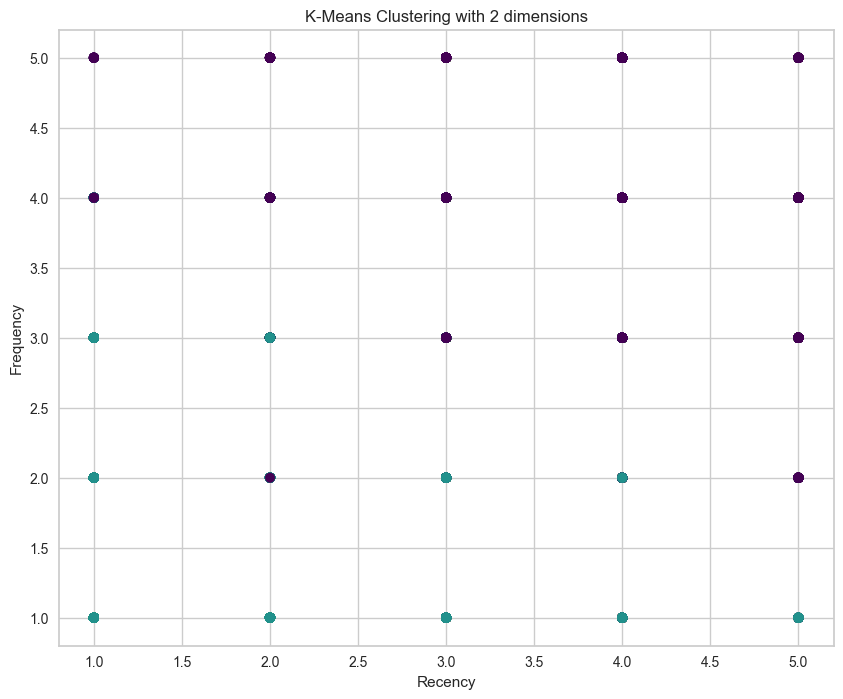

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(rfm_and_country_df.iloc[:, 1], rfm_and_country_df.iloc[:, 2], c=clusters_predict, cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('K-Means Clustering with 2 dimensions')
plt.show()

In [22]:
rfm_and_country_df

,CustomerID,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
0,12346.0,1.0,1.0,1.0,34.0
2,12348.0,2.0,3.0,4.0,12.0
3,12349.0,4.0,4.0,4.0,17.0
4,12350.0,1.0,2.0,2.0,23.0
5,12352.0,3.0,4.0,4.0,23.0
...,...,...,...,...,...
4366,18278.0,2.0,1.0,1.0,34.0
4367,18280.0,1.0,1.0,1.0,34.0
4368,18281.0,1.0,1.0,1.0,34.0
4369,18282.0,5.0,1.0,1.0,34.0


In [24]:
rfm_and_country_df.iloc[:, 1:4]

,RecencyScore,FrequencyScore,MonetaryScore
0,1.0,1.0,1.0
2,2.0,3.0,4.0
3,4.0,4.0,4.0
4,1.0,2.0,2.0
5,3.0,4.0,4.0
...,...,...,...
4366,2.0,1.0,1.0
4367,1.0,1.0,1.0
4368,1.0,1.0,1.0
4369,5.0,1.0,1.0


In [25]:
pca_3d_object, df_pca_3d = get_pca_3d(rfm_and_country_df.iloc[:, 1:4], clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.012        67.08%                     67.08%
1              0.707        23.58%                     90.65%
2              0.280         9.35%                    100.00%


In [75]:
# append the cluster labels to the original dataframe
rfm_and_country_df['cluster'] = clusters_predict
rfm_and_country_df.iloc[:, 1:]

,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel,cluster
0,1.0,1.0,1.0,34.0,2
2,2.0,3.0,4.0,12.0,1
3,4.0,4.0,4.0,17.0,1
4,1.0,2.0,2.0,23.0,4
5,3.0,4.0,4.0,23.0,4
...,...,...,...,...,...
4366,2.0,1.0,1.0,34.0,2
4367,1.0,1.0,1.0,34.0,2
4368,1.0,1.0,1.0,34.0,2
4369,5.0,1.0,1.0,34.0,2


In [76]:
# analyze the clusters' characteristics
copy = rfm_and_country_df.iloc[:, 1:].groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

,cluster,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel,TotalRFM
0,0,3.691589,3.847169,3.813634,1819,11.352391
1,1,2.976415,2.962264,3.231132,212,9.169811
2,2,2.049494,1.810005,1.821181,1879,5.680681
3,3,2.500000,2.935484,3.387097,62,8.822581
4,4,2.921053,2.907895,3.184211,76,9.013158


In [77]:
# plot the cluster characteristics
fig = go.Figure()
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["RecencyScore"],
    name='RecencyScore',
    marker_color='indianred'
))
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["FrequencyScore"],
    name='FrequencyScore',
    marker_color='lightsalmon'
))
fig.add_trace(go.Bar(
    x=copy["cluster"],
    y=copy["MonetaryScore"],
    name='MonetaryScore',
    marker_color='lightblue'
))


fig.update_layout(
    title='Cluster Characteristics',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Value',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0.85,
        y=0.95,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, 
    bargroupgap=0.1 
)
fig.show()

In [224]:
rfm_scaled_no_outliers

,CustomerID.1,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
2,12348.0,2.0,3.0,4.0,12.0
3,12349.0,4.0,4.0,4.0,17.0
4,12350.0,1.0,2.0,2.0,23.0
5,12352.0,3.0,4.0,4.0,23.0
7,12354.0,1.0,3.0,4.0,29.0
...,...,...,...,...,...
4366,18278.0,2.0,1.0,1.0,34.0
4367,18280.0,1.0,1.0,1.0,34.0
4368,18281.0,1.0,1.0,1.0,34.0
4369,18282.0,5.0,1.0,1.0,34.0


In [225]:
# merge the original data with the clusters
rfm_scaled_no_outliers['cluster'] = clusters_predict

In [226]:
# analyze the clusters' characteristics
copy = rfm_scaled_no_outliers.groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

,cluster,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel,TotalRFM
0,0,3.745794,2.201869,2.167290,1070,8.114953
1,1,3.652847,4.253094,4.246906,1616,12.152847
2,2,1.457532,1.978365,2.056090,1248,5.491987


In [227]:
# plot the clusters in 3d using scikit-learn
from sklearn.calibration import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rfm_scaled_no_outliers.iloc[:, 1:5], clusters_predict)

rfm_scaled_no_outliers['cluster'] = clusters_predict
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category')
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.rename_categories(['cluster_1', 'cluster_2', 'cluster_3'])

# convert categorical variable to numerical
# le = LabelEncoder()
# rfm_scaled_no_outliers['cluster'] = le.fit_transform(rfm_scaled_no_outliers['cluster'])
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].astype('category') # convert back to category type
# rfm_scaled_no_outliers['cluster'] = rfm_scaled_no_outliers['cluster'].cat.codes

# plot it
fig = px.scatter_3d(rfm_scaled_no_outliers, 
                        x='RecencyScore', 
                        y='FrequencyScore', 
                        z='MonetaryScore',
                        color='cluster',
                        template="plotly",
                        
                        # symbol = "cluster",
                        
                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title="title").update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": 0.8,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": 0.1,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000, 
                                height = 800, 
                                autosize = False, 
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))
                      
    
fig.show()

In [172]:
rfm_scaled_no_outliers


,CustomerID.1,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel,cluster
2,12348.0,2.0,3.0,4.0,12.0,1
3,12349.0,4.0,4.0,4.0,17.0,1
4,12350.0,1.0,2.0,2.0,23.0,2
5,12352.0,3.0,4.0,4.0,23.0,1
7,12354.0,1.0,3.0,4.0,29.0,2
...,...,...,...,...,...,...
4366,18278.0,2.0,1.0,1.0,34.0,2
4367,18280.0,1.0,1.0,1.0,34.0,2
4368,18281.0,1.0,1.0,1.0,34.0,2
4369,18282.0,5.0,1.0,1.0,34.0,0


In [180]:
rfm_scaled_no_outliers.iloc[:, 1:5]

,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel
2,2.0,3.0,4.0,12.0
3,4.0,4.0,4.0,17.0
4,1.0,2.0,2.0,23.0
5,3.0,4.0,4.0,23.0
7,1.0,3.0,4.0,29.0
...,...,...,...,...
4366,2.0,1.0,1.0,34.0
4367,1.0,1.0,1.0,34.0
4368,1.0,1.0,1.0,34.0
4369,5.0,1.0,1.0,34.0


In [228]:
# analyze the clusters' characteristics
copy = rfm_scaled_no_outliers.groupby("cluster").agg(
    {
        "RecencyScore": "mean", 
        "FrequencyScore": "mean", 
        "MonetaryScore": "mean", 
        "CountryLabel": "count"
    }
).reset_index()

# add total rfm score
copy["TotalRFM"] = copy["RecencyScore"] + copy["FrequencyScore"] + copy["MonetaryScore"]
copy

,cluster,RecencyScore,FrequencyScore,MonetaryScore,CountryLabel,TotalRFM
0,0,3.745794,2.201869,2.167290,1070,8.114953
1,1,3.652847,4.253094,4.246906,1616,12.152847
2,2,1.457532,1.978365,2.056090,1248,5.491987


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9642
[LightGBM] [Info] Number of data points in the train set: 88798, number of used features: 4
[LightGBM] [Info] Start training from score -1.407670
[LightGBM] [Info] Start training from score -0.993865
[LightGBM] [Info] Start training from score -0.954138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

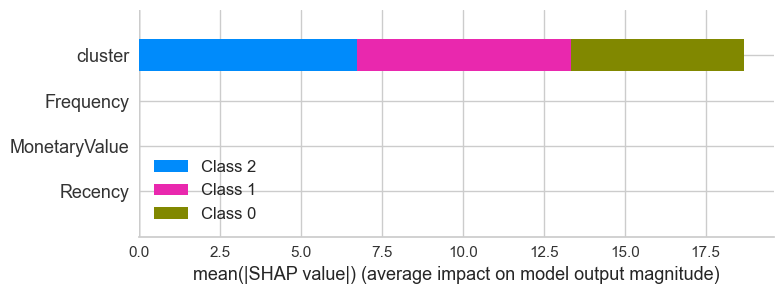

In [131]:
from cv2 import exp
import lightgbm as lgb
from numpy import shape
import shap

clf_km = lgb.LGBMClassifier()

for col in rfm_scaled_no_outliers.columns[1:]:
    rfm_scaled_no_outliers[col] = rfm_scaled_no_outliers[col].astype('category')
    
clf_km.fit(rfm_scaled_no_outliers.iloc[:, 1:], clusters_predict)

explainer = shap.TreeExplainer(clf_km)
shape_values = explainer.shap_values(rfm_scaled_no_outliers.iloc[:, 1:])
shap.summary_plot(shape_values, rfm_scaled_no_outliers.iloc[:, 1:], plot_type="bar")